<h2>Contents</h2>

* [Imports](#imports)
* [First Look](#first_look)
* [Data Cleanup](#cleanup)
    * [Owner Data](#owner_data)
    * [Pet Data](#pet_data)
    * [Province Lookup by Postal Code](#province_lookup)
* [Creating/Writing SQL Tables](#writing_tables)
* [Review of Output](#output)
    * [Owners Table](#owners)
    * [Pets Table](#pets)
    * [License Table](#license)
    * [Valid Entries](#valid)
    * [Invalid Entries](#invalid)
* [Insights](#insights)


**Valid and Invalid full .csv file can be downloaded on git.**

Git Repository: https://github.com/n-mazzotta/data-challenge


<h3 id="imports">Imports</h3>

In [1]:
#!pip install pypostalcode
from pypostalcode import PostalCodeDatabase # For getting province by postal code
import pandas as pd
import csv
import json
pd.options.mode.chained_assignment = None
import re ## Regular expressions for cleaning up strings - phone #'s
import dateutil.parser as date_parse # For easily converting dates to same format
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("./Data Challenge.csv") 

<h3 id="first_look">First Look at Data</h3>

Let's start by taking a look at the data.

I see a feature called **Last Mane** - DocuPet: Horse Series coming soon?

In [3]:
df.columns

Index(['Owner First ', 'Customer Number', 'Last Mane', 'Number', 'Street Name',
       'Unit', 'City', 'Postal Code', 'Province', 'Owner Phone',
       'Alternate Phone', 'Pet Species', 'Last Renewal date', 'Pet Name',
       'Pet Breed', 'Pet Colour', 'Pet Sex', 'Pet is fixed', 'Tag #',
       'Owner Email', 'Expiry year', 'Sold By', 'Tag Status', 'Rabies Expiry',
       'Pet Status'],
      dtype='object')

Let's change that **Last Mane** to **Last Name**.

We are also going to change **Number** to **Street Number** for clarity.

In [4]:
df = df.rename(columns={"Last Mane": "Last Name", "Number": "Street Number", "Owner First ":"First Name"})

In [5]:
df[["Customer Number","Tag #"]].dtypes

Customer Number    int64
Tag #              int64
dtype: object

**Customer Number** and **Tag #** should be int

In [6]:
int_cols = ["Customer Number", "Tag #"]
for col in int_cols:
    df[col] = df[col].astype(int)


I see a lot of NaN in the **Province** feature, let's see what the other values look like.

In [7]:
df.groupby("Province").agg("count")

,First Name,Customer Number,Last Name,Street Number,Street Name,Unit,City,Postal Code,Owner Phone,Alternate Phone,...,Pet Colour,Pet Sex,Pet is fixed,Tag #,Owner Email,Expiry year,Sold By,Tag Status,Rabies Expiry,Pet Status
Province,,,,,,,,,,,,,,,,,,,,,
CA,16,16,16,16,16,5,16,16,16,7,...,15,16,15,16,16,16,16,2,16,16
NB,17,17,17,17,17,4,17,17,17,11,...,13,16,17,17,16,17,17,2,17,16
ON,16,16,16,16,16,4,16,16,16,9,...,14,16,16,16,16,16,16,2,16,15
ONTARIO,21,21,21,21,21,12,21,21,21,10,...,19,20,21,21,20,21,21,4,21,21
Ontario,18,18,18,18,18,9,18,18,18,8,...,16,17,18,18,18,18,18,1,18,18
QC,12,12,12,12,12,5,12,12,12,8,...,11,12,12,12,11,12,12,2,12,12


<h2 id="cleanup">Data Cleanup</h2>

<h3 id="owner_data">Owner Data</h3>

Looks like we have some inconsistent formatting in a few columns.

Make everything uppercase, fill the NaNs so we can start fixing it up.

We will start with **Province**.

In [8]:
cols = ["City", "Province", "Pet Species", "Pet Sex", "Pet is fixed", "Pet Colour", "Pet Status"]
for col in cols:
    df[col] = df[col].str.upper()

And do the same for the **City** column where any string with `a` becomes `A`; any string with `b` becomes `B`

In [9]:
df.loc[df["City"].str.contains("A"), 'City'] = "A"
df.loc[df["City"].str.contains("B"), 'City'] = "B"
## Some remaining with just "CITY", let's set to nan
df.loc[df["City"].str.contains("CITY"), 'City'] = np.nan

In [10]:
df["City"].unique()

array(['A', nan, 'B'], dtype=object)

Getting rid of any non-numeric values in phone numbers.

In [11]:
df["Owner Phone"] = df["Owner Phone"].str.replace("[^0-9]", "")
df["Alternate Phone"] = df["Alternate Phone"].str.replace("[^0-9]", "")

<h3 id="pet_data">Pet Data</h3>

And again for other features with lots of bad values.

**Ideally we would have a file for all of these mappings with accepted values, but I have hardcoded them here.**

In [12]:
## Establish what means what in some lists
is_male = ["M","BOY","MALE","ML","MA","MAL"]
is_female = ["F","GIRL","FEMALE", "FEM"]
all_gender_values = is_male + is_female

## Repeat for Fixed
is_fixed = ["Y","YES","S","SPAYED","NEUTER", "NEUTERED"]
is_not_fixed = ["N","NO","INTACT"]
all_fixed_values = is_fixed + is_not_fixed

## Repeat for Species
is_cat = ["C","CAT", "CT"]
is_dog = ["D","DOG", "DG"]
all_species = is_cat + is_dog

## Repeat for Status
is_active = ["A","ACTIVE"]
is_inactive = ["R", "REMOVED","MOVED", "EXPIRED", "INACTIVE"]
all_status = is_active + is_inactive

## Repeat for colour
is_color = ["BLACK","BLACK/TAN","BLUE","CREAM","MIX","ORANGE","PURPLE","TAN","TRI","WHITE"]

## Not a colour?
is_not_color = all_gender_values + all_fixed_values + all_species + all_status

## I want to do all of this next bit in one loop, so I am defining some dictionaries I can refer to.
target_columns = {
    "Pet Sex":{
        "condition1":{"list":is_male,"value":"M"},
        "condition2":{"list":is_female,"value":"F"}
        },
    "Pet is fixed":{
        "condition1":{"list":is_fixed,"value":"YES"},
        "condition2":{"list":is_not_fixed,"value":"NO"}
        },
    "Pet Species":{
        "condition1":{"list":is_cat,"value":"CAT"},
        "condition2":{"list":is_dog,"value":"DOG"}
        },
    "Pet Status":{
        "condition1":{"list":is_active,"value":"ACTIVE"},
        "condition2":{"list":is_inactive,"value":"REMOVED"}
        },
    "Pet Colour":{
        "condition1":{"list":is_color,"value":""},
        "condition2":{"list":is_not_color,"value":np.nan}
        }
}

## Loop through all of the columns we want cleaned up and set the value to an "accepted" one.
for target in target_columns:
    if target == "Pet Colour":
        for row in df[target]:
            if row in is_color:
                pass
            elif row not in is_color:
                df.loc[df[target] == row, target] = target_columns[target]["condition2"]["value"] 
    elif target != "Pet Colour":
        for row in df[target]:
            if row in target_columns[target]["condition1"]["list"]:
                df.loc[df[target] == row, target] = target_columns[target]["condition1"]["value"]
            elif row in target_columns[target]["condition2"]["list"]:
                df.loc[df[target] == row, target] = target_columns[target]["condition2"]["value"]
            else:
                df.loc[df[target] == row, target] = np.nan


Now we can see that all our records are binned nicely into categories.

Next, we will grab whatever provinces we can from the postal codes (100 of the provided postal codes correlate to a real location, the others do not).

We could apply the same methodology to grab any of the City, Postal Code, or Province if we have just one of them. Given that this is not real data, we will have to **remove the 22 entries that we are unable to determine City for.**

<h3 id="province_lookup">Province Lookup by Postal Code</h3>

Let's try and grab as many Provinces from the postal code values as we can.

First we will split the data into two categories: entries with a valid **Province**, and entries without one.

We also take an inventory of the postal codes we couldn't get a match for.

ref: https://github.com/inkjet/pypostalcode

In [13]:
error_count = 0
error_postals = []

## The PostalCodeDatabse library only returns in full Province name, so I made a JSON mapping file 
## to get the abbreviated name.
with open("./province_mapping.json") as jsonfile:
    province_abbrev = json.load(jsonfile)
df["Province"].fillna(np.nan)
## Grab valid Province
# We have a province labeled "CA" which is not correct - put it in the bad value dataframe.
df_with_province = df.loc[((df["Province"] != "CA") & (df["Province"].str.len() == 2))]
## Grab invalid Province
df_without_province = df.loc[((df["Province"].str.len() != 2) | (df["Province"] == "CA"))]

## Look for province based on Postal Code
for row in df_without_province["Postal Code"]:
        try:
            pcdb = PostalCodeDatabase()
            postal = row[:3]
            location = pcdb[postal]
            province = location.province
            df_without_province.loc[df["Postal Code"] == row, "Province"] = province_abbrev[province]
        except:
            df_without_province.loc[df["Postal Code"] == row, "Province"] = np.nan
            error_postals.append(row)
            error_count += 1  
            
## Append the two DataFrames back together
df = df_with_province.append(df_without_province)

<h3 id="date_format">Date Formatting</h3>

In [14]:
date_cols = ["Last Renewal date", "Expiry year", "Rabies Expiry"]

for col in date_cols:
    df[col] = df[col].astype(str)
    for row in df[col]:
        try:
            x = date_parse.parse(row)
            df.loc[df[col] == row, col] = x
        except:
            print(col,row)

Expiry year 2018-06-14 00:00:00
Expiry year 2014-01-01 00:00:00
Expiry year 2012-01-28 00:00:00
Rabies Expiry 2016-07-25 00:00:00
Rabies Expiry 2005-02-01 00:00:00


<h3 id="validity_split">Splitting Data by Valid / Invalid Submissions</h3>

Now that we have cleaned up as much as we can, let's split into entries that are valid submissions and those that have a NaN in  one of the required fields.

In [15]:
df.columns = df.columns.str.replace(' ', '_')
df = df.fillna(np.nan)

target_cols =["First_Name","Last_Name", "Street_Number","Street_Name", "City","Postal_Code",
              "Province", "Owner_Phone", "Pet_Name", "Pet_Species", "Pet_Breed", "Pet_Colour", "Pet_Sex", "Pet_is_fixed", 
              "Tag_#", "Last_Renewal_date", "Expiry_year"]


invalid = df[df[target_cols].isnull().any(axis=1)]
valid = df.dropna(subset=target_cols)
invalid.to_csv("./invalid_entry_list.csv")
valid.to_csv("./valid_entry_list.csv")

<h2 id="writing_tables">Establishing Database and Writing Tables</h2>

In [16]:
## Create an SQLite DB.
db = sqlite3.connect("DocuPet.db")

## Let's define what columns we want in our tables.
owner_cols = ["Customer_Number","First_Name","Last_Name", "Street_Number","Street_Name", "Unit", "City","Postal_Code",
              "Province", "Owner_Phone", "Alternate_Phone", "Owner_Email"]

pet_cols = ["Customer_Number", "Tag_#", "Pet_Name", "Pet_Status", "Pet_Species", "Pet_Breed", "Pet_Colour", "Pet_Sex", "Pet_is_fixed", 
            "Rabies_Expiry"]

license_cols = ["Tag_#", "Customer_Number", "Last_Renewal_date", "Expiry_year", "Sold_By", "Tag_Status"]

## Set the right index for each table and create the table in the DocuPet DB.
# Customer_Number is the right index here so we leave it.
df_owners = valid[owner_cols].drop_duplicates()
# We have some duplicate customers becuase of multiple postal codes. Remove them
dupe_owners = df_owners.duplicated(subset="Customer_Number")
df_owners = df_owners.assign(customer_is_dupe = dupe_owners)
df_owners = df_owners[df_owners["customer_is_dupe"] == False]
df_owners.drop("customer_is_dupe", axis=1, inplace=True)

df_owners.set_index("Customer_Number", inplace=True)
df_owners.to_sql("owners", db)

# Create a new index to identify each pet.
df_pets = valid[pet_cols].reset_index(drop=True)
df_pets.index.names = ["Pet_ID"]
df_pets.drop_duplicates().to_sql("pets", db)

# Set the index to the Tag #.
df_licenses = valid[license_cols].reset_index(drop=True)
df_licenses.set_index("Tag_#", inplace=True)
df_licenses.drop_duplicates().to_sql("licenses", db)

<h2 id="output">Review of Output</h2>

We started off with 200 rows of data, and ended up with 43 valid entries.

In [17]:
print("Invalid: ",df.shape[0])
print("Valid: ",valid.shape[0])

Invalid:  200
Valid:  43


We have saved the invalid entries to a file called `invalid_entry_list`, as well as creating some tables in a database with the remaining valid entries.

We have created 3 tables (click blank space below code snippet to expand).

<h3 id="owners">Owners Table</h3>

In [18]:
df_owners

,First_Name,Last_Name,Street_Number,Street_Name,Unit,City,Postal_Code,Province,Owner_Phone,Alternate_Phone,Owner_Email
Customer_Number,,,,,,,,,,,
3230,Orla,Castaneda,155,Fance Place,V,B,J5X 9M7,ON,13175530572,1632710899,Donec.sollicitudin@Etiamimperdiet.net
4908,Angela,Ewing,185,Real St,NaN,A,X3Z 7B9,NB,6854912138,4151334089,gravida.sagittis@Donecvitaeerat.com
7672,Amela,Malone,72,Fance Place,NaN,B,J4J 6V8,NB,5873522859,6104369,egestas.Duis.ac@loremDonecelementum.com; test@...
1638,Lillith,Talley,33,Real St,NaN,A,T1M 7J7,NB,13787929331,1273795106,ullamcorper@mauris.com
6301,Elizabeth,Burnett,158,Fance Place,NaN,A,C7H 2V3,NB,4307320501,NaN,luctus.et.ultrices@idenimCurabitur.net
5395,Flynn,Johns,10,Fance Place,NaN,A,H0B 3V8,QC,1488978,7154803558,ante@sapienmolestieorci.com
6134,Ivy,Weiss,8,Real St,NaN,A,B7W 6K7,ON,5258218,NaN,tincidunt.aliquam.arcu@lectusa.edu
5984,Harriet,Alvarado,158,Real St,D,A,K1K 6S2,ON,14943137445,13027134726,purus.Maecenas@fringillacursuspurus.co.uk
5155,Erin,Cervantes,176,Fance Place,NaN,A,R1N 0L2,ON,14309273971,6905652919,Sed.eu@augue.org


<h3 id="licenses">Licenses Table</h3>

In [19]:
df_licenses

,Customer_Number,Last_Renewal_date,Expiry_year,Sold_By,Tag_Status
Tag_#,,,,,
3898,3230,2001-01-14,2016-02-22,Regan,NaN
2853,4908,2015-11-16,2015-01-09,Cairo,NaN
5346,7672,1983-12-14,2016-05-03,Jeremy,NaN
7478,1638,2005-02-24,2013-06-19,Oren,NaN
8127,6301,1996-07-18,2004-10-15,Dara,NaN
9930,5395,2005-03-20,2002-10-03,Amity,NaN
8047,6134,2007-05-27,2006-06-24,Talon,No
9963,5984,1986-03-18,2017-10-18,Emerald,NaN
6016,6134,1998-06-12,2001-12-07,Thomas,NaN


<h3 id="pets">Pets Table</h3>

In [20]:
df_pets

,Customer_Number,Tag_#,Pet_Name,Pet_Status,Pet_Species,Pet_Breed,Pet_Colour,Pet_Sex,Pet_is_fixed,Rabies_Expiry
Pet_ID,,,,,,,,,,
0,3230,3898,Allen,ACTIVE,DOG,Pom,WHITE,M,YES,2014-03-27
1,4908,2853,Mercedes,ACTIVE,CAT,Pom,TRI,F,YES,2013-10-21
2,7672,5346,Hope,ACTIVE,CAT,Shih tzu,TAN,M,YES,2012-01-08
3,1638,7478,Ignacia,ACTIVE,DOG,POOGLE,TRI,M,YES,2005-02-01
4,6301,8127,William,ACTIVE,DOG,Aust Shepherd,BLACK,F,NO,2012-03-05
5,5395,9930,Latifah,ACTIVE,DOG,Shepherd,CREAM,M,YES,1998-01-03
6,6134,8047,Jocelyn,ACTIVE,CAT,Maltese,BLACK/TAN,F,YES,2002-06-13
7,5984,9963,Violet,REMOVED,CAT,Terrier,TRI,F,YES,1996-05-12
8,6134,6016,Kadeem,ACTIVE,DOG,Shih tzu,PURPLE,F,NO,2016-09-04


<h3 id="valid">Valid Entries</h3>

In [24]:
valid

,First_Name,Customer_Number,Last_Name,Street_Number,Street_Name,Unit,City,Postal_Code,Province,Owner_Phone,...,Pet_Colour,Pet_Sex,Pet_is_fixed,Tag_#,Owner_Email,Expiry_year,Sold_By,Tag_Status,Rabies_Expiry,Pet_Status
10,Orla,3230,Castaneda,155,Fance Place,V,B,J5X 9M7,ON,13175530572,...,WHITE,M,YES,3898,Donec.sollicitudin@Etiamimperdiet.net,2016-02-22,Regan,NaN,2014-03-27,ACTIVE
22,Angela,4908,Ewing,185,Real St,NaN,A,X3Z 7B9,NB,6854912138,...,TRI,F,YES,2853,gravida.sagittis@Donecvitaeerat.com,2015-01-09,Cairo,NaN,2013-10-21,ACTIVE
35,Amela,7672,Malone,72,Fance Place,NaN,B,J4J 6V8,NB,5873522859,...,TAN,M,YES,5346,egestas.Duis.ac@loremDonecelementum.com; test@...,2016-05-03,Jeremy,NaN,2012-01-08,ACTIVE
38,Lillith,1638,Talley,33,Real St,NaN,A,T1M 7J7,NB,13787929331,...,TRI,M,YES,7478,ullamcorper@mauris.com,2013-06-19,Oren,NaN,2005-02-01,ACTIVE
41,Elizabeth,6301,Burnett,158,Fance Place,NaN,A,C7H 2V3,NB,4307320501,...,BLACK,F,NO,8127,luctus.et.ultrices@idenimCurabitur.net,2004-10-15,Dara,NaN,2012-03-05,ACTIVE
66,Flynn,5395,Johns,10,Fance Place,NaN,A,H0B 3V8,QC,1488978,...,CREAM,M,YES,9930,ante@sapienmolestieorci.com,2002-10-03,Amity,NaN,1998-01-03,ACTIVE
67,Ivy,6134,Weiss,8,Real St,NaN,A,B7W 6K7,ON,5258218,...,BLACK/TAN,F,YES,8047,tincidunt.aliquam.arcu@lectusa.edu,2006-06-24,Talon,No,2002-06-13,ACTIVE
89,Harriet,5984,Alvarado,158,Real St,D,A,K1K 6S2,ON,14943137445,...,TRI,F,YES,9963,purus.Maecenas@fringillacursuspurus.co.uk,2017-10-18,Emerald,NaN,1996-05-12,REMOVED
108,Ivy,6134,Weiss,8,Real St,NaN,A,Y7T 8Z2,ON,5258218,...,PURPLE,F,NO,6016,Quisque.tincidunt@non.co.uk,2001-12-07,Thomas,NaN,2016-09-04,ACTIVE
125,Erin,5155,Cervantes,176,Fance Place,NaN,A,R1N 0L2,ON,14309273971,...,ORANGE,F,NO,5575,Sed.eu@augue.org,2012-02-15,Lani,NaN,2008-03-29,NaN


<h3 id="invalid">Invalid Entries</h3>

In [25]:
invalid

,First_Name,Customer_Number,Last_Name,Street_Number,Street_Name,Unit,City,Postal_Code,Province,Owner_Phone,...,Pet_Colour,Pet_Sex,Pet_is_fixed,Tag_#,Owner_Email,Expiry_year,Sold_By,Tag_Status,Rabies_Expiry,Pet_Status
6,Quintessa,4893,Bolton,155,Fance Place,NaN,B,S3X 4Z0,ON,17051853744,...,NaN,M,NO,3950,dolor.quam@CurabiturdictumPhasellus.com,2001-04-05,Janna,NaN,2019-05-14,ACTIVE
15,Ivy,6134,Weiss,8,Real St,NaN,A,A6Z 9S2,ON,5258217,...,NaN,F,NO,5287,Cras.pellentesque.Sed@facilisis.net,2017-11-03,Wayne,NaN,1997-12-25,NaN
16,Ivy,6134,Weiss,8,Real St,NaN,A,A6Z 9S3,ON,5258218,...,TAN,NaN,YES,4518,Cras.pellentesque.Sed@facilisis.net,2013-08-25,Unity,NaN,2003-11-26,ACTIVE
27,Cathleen,7007,Watts,125,Real St,NaN,B,J2B 4X0,NB,4962180,...,TRI,NaN,NO,3655,rutrum.non@justoPraesentluctus.com,2009-07-17,Upton,NaN,2014-07-27,ACTIVE
36,Inga,9349,Torres,96,Fance Place,02-Jan,B,L2N 4Z6,QC,5634169,...,BLACK,F,YES,3017,dui@scelerisquescelerisquedui.com,2007-03-31,Dustin,NaN,2000-07-11,ACTIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,Chancellor,2085,Colon,140,Real St,NaN,A,B7P 7S3,NaN,2120268,...,MIX,M,NO,9014,est.arcu@Integerin.edu,2014-10-16,Iona,NaN,2017-09-14,ACTIVE
195,Kareem,2501,Ferrell,132,Brampton Street,NaN,A,S4N 3E3,SK,2505821,...,BLUE,NaN,NO,4404,Nam.consequat.dolor@ipsumdolorsit.co.uk,2015-04-16,Donna,NaN,2001-09-07,REMOVED
196,Armand,7525,Langley,74,Brampton Street,C,B,L4P 3W1,ON,5721358520,...,PURPLE,M,NO,9725,nibh.sit@malesuadavelconvallis.ca,2002-08-27,Perry,NaN,2005-11-27,ACTIVE
198,Eagan,3837,Holloway,33,NaN,NaN,A,N2G 2L3,ON,1283140737,...,BLACK/TAN,F,YES,1194,dui@urnaNunc.org,2015-12-04,Christian,NaN,2018-06-09,ACTIVE


<h2 id="insights">Insights</h2>

All findings are hypothetical and making the assumption that the postal codes correlate to real locations.

Despite accounting for only ~16% of all entries, Quebec sent in the most bad submissions representing ~30% of invalid entries.

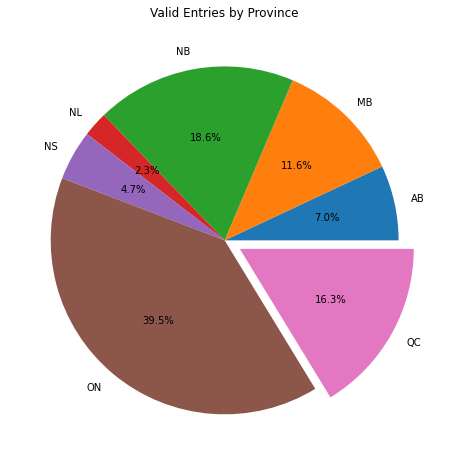

In [21]:
valid_by_province = valid.groupby("Province").agg("count").reset_index()
x = valid_by_province["Province"]
y = valid_by_province["Tag_#"]
explode = (0,0,0,0,0,0,0.1)
fig1, ax1 = plt.subplots(figsize=(8,8))

ax1.pie(y, labels=x, explode=explode, autopct='%1.1f%%')
plt.title("Valid Entries by Province")
plt.show()

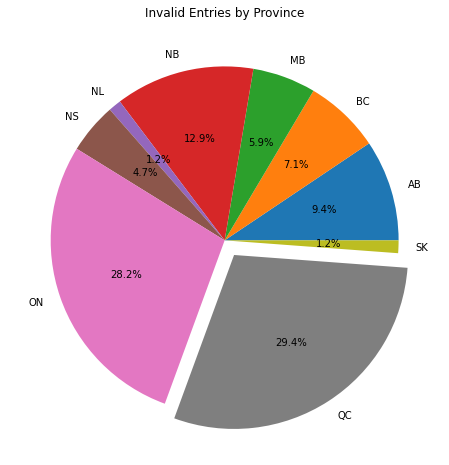

In [22]:
invalid_by_province = invalid.groupby("Province").agg("count").reset_index()
x = invalid_by_province["Province"]
y = invalid_by_province["Tag_#"]
explode = (0,0,0,0,0,0,0,0.1,0)
fig1, ax1 = plt.subplots(figsize=(8,8))

ax1.pie(y, labels=x, explode=explode, autopct='%1.1f%%')
plt.title("Invalid Entries by Province")
plt.show()

The biggest lost of entries was due to no **Province** value. 

We started with 115 missing values for province, but were able to recover ~37.4% of them using postal code lookup. I expect this would be much higher on real data.

In [23]:
invalid_by_field = df.isna().sum().to_frame().reset_index().rename(columns={"index":"Field",0:"Sum of NaN"})
invalid_by_field = invalid_by_field[invalid_by_field["Sum of NaN"] > 0]
invalid_by_field.sort_values("Sum of NaN", ascending = False)

,Field,Sum of NaN
22,Tag_Status,178
5,Unit,131
10,Alternate_Phone,80
8,Province,72
15,Pet_Colour,59
16,Pet_Sex,58
11,Pet_Species,28
6,City,22
24,Pet_Status,19
17,Pet_is_fixed,6
